In [1]:
import pickle
import numpy
import math
import json

import matplotlib.pyplot as plt
from matplotlib import colors as plt_colors
from matplotlib import cm
import matplotlib as mpl

from evaluator import define_parameters, define_fitness_calculator

mpl.rcParams['mathtext.default'] = 'regular'
cmap = mpl.colormaps['viridis']

In [2]:
optimization_folder = "20250124-081229_Optimization"
config_optimisation = "./param/config_optimisation"
checkpoint_path = f"./{optimization_folder}/opt_check.pkl"

In [3]:
with open(config_optimisation) as f:
    opt_config = json.load(f)
fitness_calculator = define_fitness_calculator(opt_config)
params = define_parameters(opt_config)
param_names = [p.name for p in params]
scores_names = [target.name for target in fitness_calculator.objectives]

In [4]:
with open(checkpoint_path, "rb") as fp:
    run = pickle.load(fp, encoding="latin1")

# Plot best solution

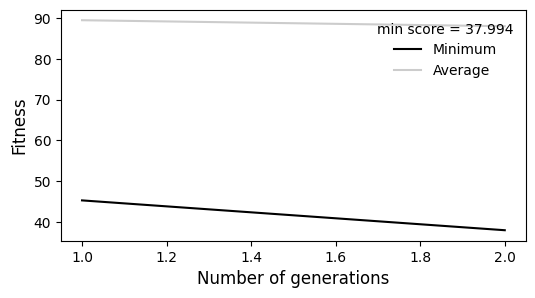

In [5]:
fig, axs = plt.subplots(1, figsize=(6, 3), squeeze=False)

axs[0, 0].plot(run["logbook"].select("gen"), run["logbook"].select("min"), label="Minimum", c="black")
axs[0, 0].plot(run["logbook"].select("gen"), run["logbook"].select("avg"), label="Average", c="gray", alpha=0.4)

axs[0, 0].set_xlabel("Number of generations", size="large")
axs[0, 0].set_ylabel("Fitness", size="large")

legend_text = "\n".join((f"min score = {min(run['logbook'].select('min')):.3f}",))
axs[0, 0].legend(title=legend_text, loc="upper right", frameon=False)

plt.savefig(f"./{optimization_folder}/evo_fitness.png", dpi=100, bbox_inches="tight", transparent=True)
plt.show()

In [6]:
print("Sigma: ", run["CMA_es"].sigma)
print("Best model:")
print("{")
for p, v in zip(param_names, run["halloffame"][0]):
    print(f'    "{p}": [{round(v, 8)}],')
print("}")

print(run["halloffame"][0])

Sigma:  0.26926211284445306
Best model:
{
    "sheets.l4_cortex_exc.L4ExcL4ExcConnection.base_weight": [0.00014461],
    "sheets.l4_cortex_exc.L4ExcL4InhConnection.base_weight": [0.00029373],
    "sheets.l4_cortex_exc.AfferentConnection.base_weight": [0.00101632],
    "sheets.l4_cortex_inh.L4InhL4ExcConnection.base_weight": [0.00100999],
    "sheets.l4_cortex_inh.L4InhL4InhConnection.base_weight": [0.00120136],
    "sheets.l4_cortex_inh.AfferentConnection.base_weight": [0.00146584],
    "sheets.l23_cortex_exc.L23ExcL23ExcConnection.base_weight": [2.658e-05],
    "sheets.l23_cortex_exc.L23ExcL23InhConnection.base_weight": [0.00021765],
    "sheets.l23_cortex_exc.L4ExcL23ExcConnection.base_weight": [0.00204417],
    "sheets.l23_cortex_exc.L23ExcL4ExcConnection.base_weight": [0.00032626],
    "sheets.l23_cortex_exc.L23ExcL4InhConnection.base_weight": [0.00021263],
    "sheets.l23_cortex_inh.L23InhL23ExcConnection.base_weight": [0.00310414],
    "sheets.l23_cortex_inh.L23InhL23InhConnectio

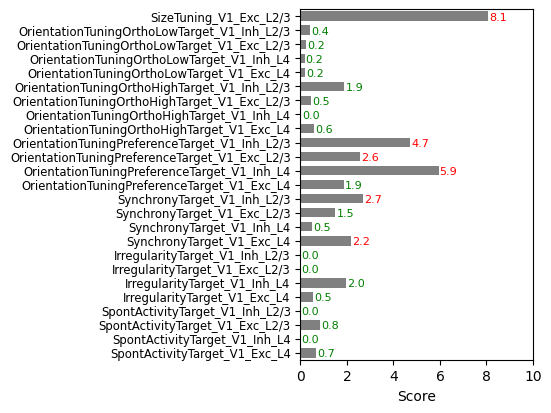

In [7]:
score = [float(f) for f in run["halloffame"][0].fitness.values]
pos = [*range(len(score))]

fig, axs = plt.subplots(1, figsize=(3, 0.8 + 0.150 * len(pos)), squeeze=False)

axs[0, 0].barh(pos, score, height=0.7, align="center", color="gray")

for p, s in zip(pos, score):
    if s > 2:
        axs[0, 0].text(s + 0.05, p - 0.25, s="{:.1f}".format(s), color="red", fontsize=8)
    if s < 2:
        axs[0, 0].text(s + 0.05, p - 0.25, s="{:.1f}".format(s), color="green", fontsize=8)

axs[0, 0].set_xlabel("Score")

axs[0, 0].set_yticks(pos)
axs[0, 0].set_yticklabels(scores_names, size="small")

axs[0, 0].set_xlim(0, 10)
axs[0, 0].set_ylim(-0.5, len(pos) - 0.5)

plt.savefig(f"./{optimization_folder}/scores.png", dpi=100, bbox_inches="tight", transparent=True)
plt.show()

# Plot correlation between parameters and scores

In [8]:
# This is an approximation since the other parameters are not fix
from scipy.stats import pearsonr

n_params = len(run["halloffame"][0])
n_targets = len(run["halloffame"][0].fitness.values)

corrs = []
for idx_param in range(n_params):

    for idx_targets in range(n_targets):

        X = []
        Y = []

        for idx_pop in run['history'].genealogy_history:
            ind = run['history'].genealogy_history[idx_pop]
            scores = numpy.array([float(v) for v in ind.fitness.values])
            X.append(ind[idx_param])
            Y.append(scores[idx_targets])

        corrs.append(pearsonr(X, Y)[0])

        """if "L23ExcL23Exc" in  param_names[idx_param]:
            plt.scatter(X, Y)
            plt.title(scores_names[idx_targets])
            plt.show()"""

corrs = numpy.array(corrs).reshape(n_params, n_targets)

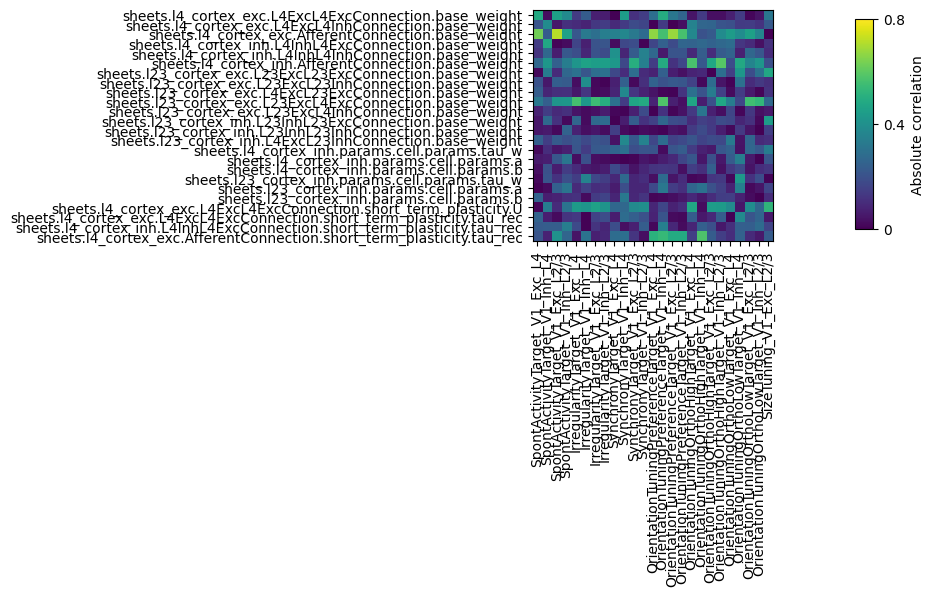

In [9]:
fig, ax = plt.subplots(1, figsize=(6, 3))

ax.imshow(numpy.abs(corrs), vmin=0, vmax=0.8)

ax.set_xticks(range(n_targets))
ax.set_xticklabels(scores_names, rotation=90)

ax.set_yticks(range(n_params))
ax.set_yticklabels(param_names)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
norm = mpl.colors.Normalize(vmin=0, vmax=0.8)

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=cbar_ax, orientation='vertical', label='Absolute correlation'
)
cbar.ax.set_yticks([0, 0.4, 0.8])
cbar.ax.set_yticklabels([0, 0.4, 0.8])

plt.savefig(f"./{optimization_folder}/correlations.png", dpi=100, bbox_inches="tight", transparent=True)
plt.show()

# Plot the CMA matrix

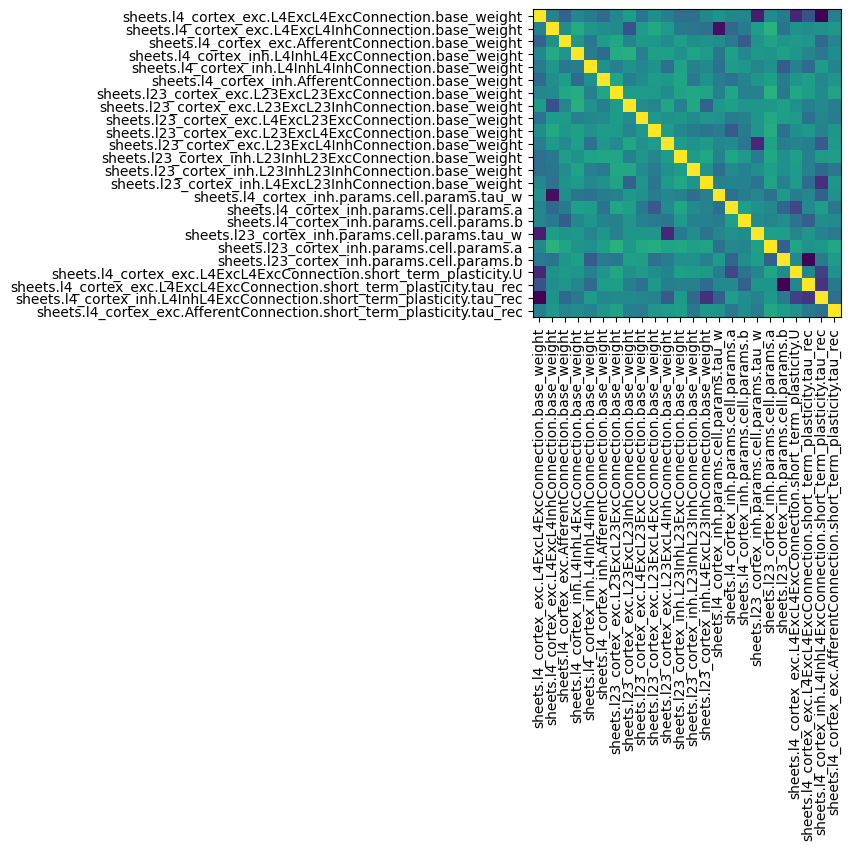

In [10]:
fig, ax = plt.subplots(1, figsize=(4, 4))

_im = numpy.log(numpy.abs(run["CMA_es"].C))
ax.imshow(_im, vmin=_im.min(), vmax=_im.max())

ax.set_xticks(range(n_params))
ax.set_xticklabels(param_names, rotation=90)

ax.set_yticks(range(n_params))
ax.set_yticklabels(param_names)
    
plt.savefig(f"./{optimization_folder}/covariance_matrix.png", dpi=100, bbox_inches="tight", transparent=True)
plt.show()

# Plot exploration of the parameter space

/tmp/ipykernel_682255/1667675349.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


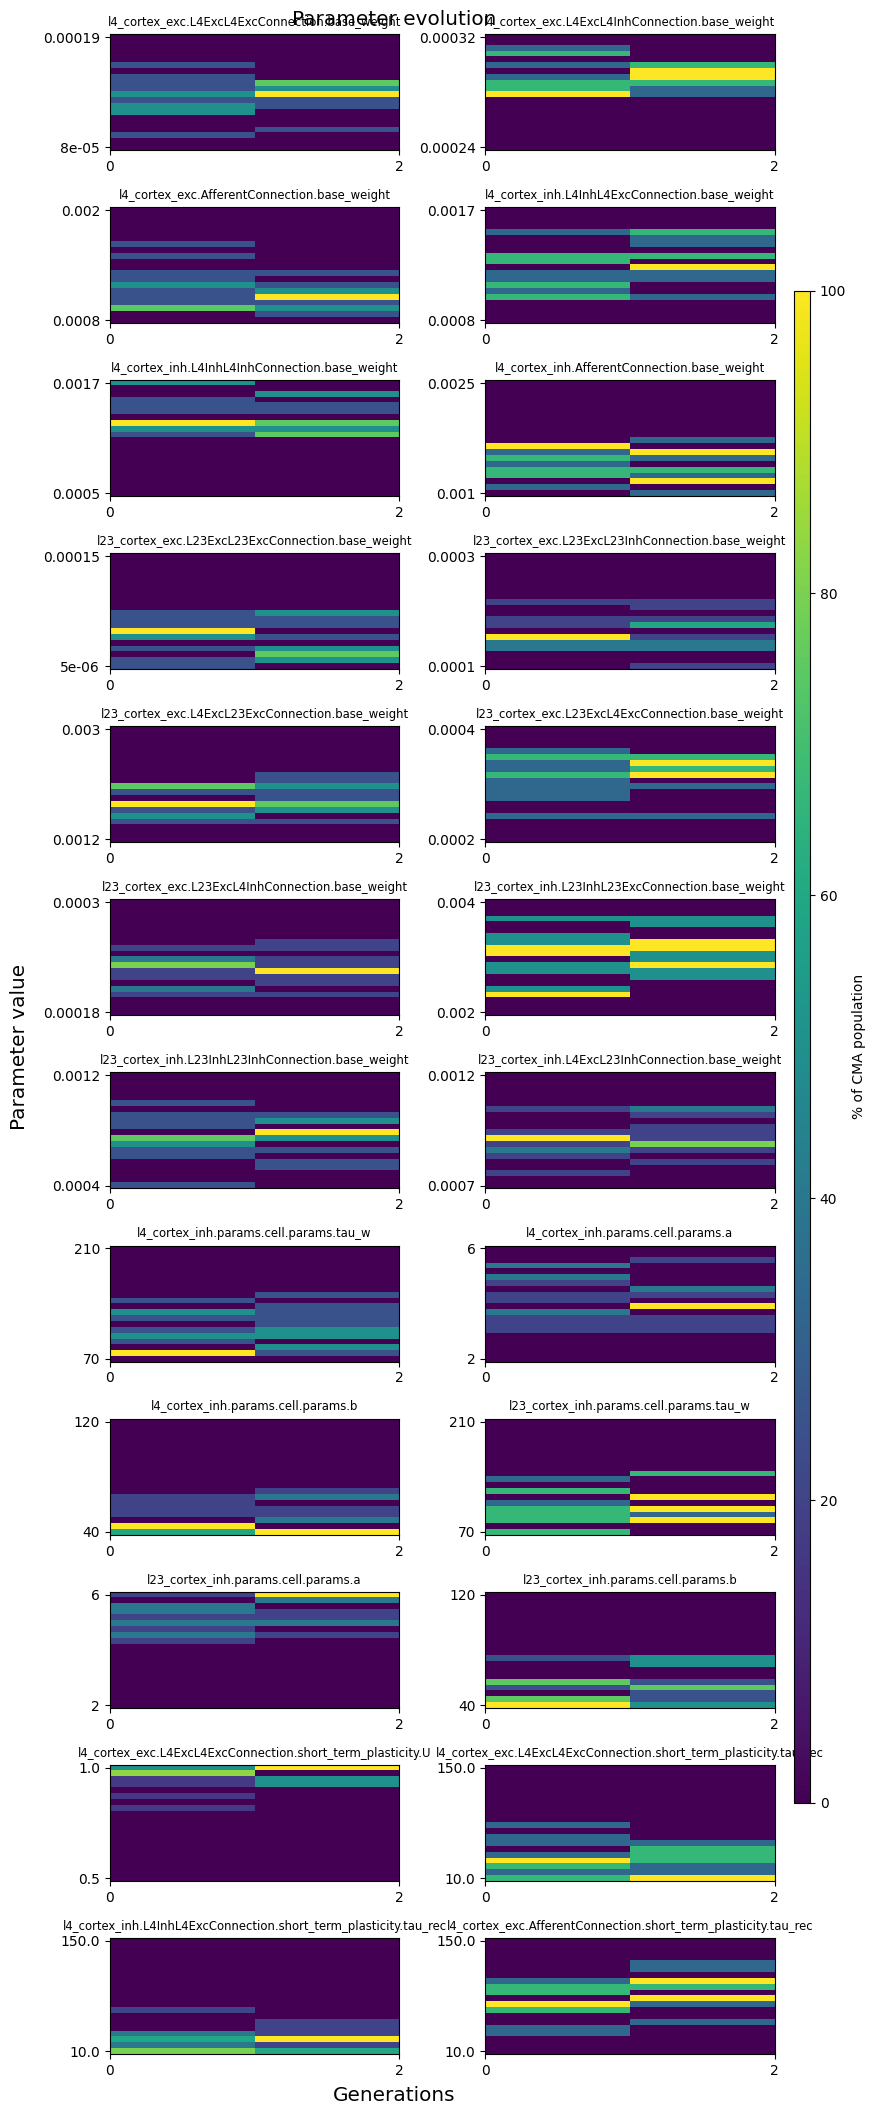

In [11]:
max_n_gen = run["generation"]
gen_per_bin = 1
pop_size = len(run["population"])
histo_bins = (int(max_n_gen / gen_per_bin), 20)
normalization_factor = gen_per_bin * pop_size

# Get the histograms for all parameters
histograms = {}
for param_index in range(len(run["history"].genealogy_history[1])):
    x = [(ind_idx - 1) // pop_size for ind_idx in run["history"].genealogy_history.keys()]
    y = [ind[param_index] for ind in run["history"].genealogy_history.values()]

    histo_range = [
        [0, max_n_gen],
        [
            params[param_index].bounds[0],
            params[param_index].bounds[1],
        ],
    ]

    h, _, _ = numpy.histogram2d(x, y, bins=histo_bins, range=histo_range)
    normalized_h = h / normalization_factor

    histograms[param_index] = normalized_h

ncols = 2
nrows = math.ceil(len(params) / ncols)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 1.8 * nrows))
axs = axs.flat

# Plot the histograms
for param_index, param in enumerate(params):
    axs[param_index].imshow(
        100.0 * numpy.flip(histograms[param_index].T, 0),
        aspect="auto",
        interpolation="none",
    )

    axs[param_index].set_title(list(param_names)[param_index].replace("sheets.", ""), size="small")

    x_ticks_pos = [0, int(max_n_gen / gen_per_bin) - 1]
    x_ticks_label = [0, int(max_n_gen / gen_per_bin) * gen_per_bin]
    axs[param_index].set_xticks(x_ticks_pos, x_ticks_label)
    axs[param_index].set_yticks([0, 19], [param.bounds[1], param.bounds[0]])
    axs[param_index].set_xlim(0, int(max_n_gen / gen_per_bin) - 1)

for axs_index in range(len(params), len(axs)):
    axs[axs_index].set_visible(False)

# Add a colorbar common to all subplots
norm = plt_colors.Normalize(vmin=0, vmax=100, clip=False)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
fig.colorbar(mappable=cm.ScalarMappable(norm=norm, cmap="viridis"), cax=cbar_ax, label="% of CMA population",)

fig.supxlabel("Generations", size="x-large")
fig.supylabel("Parameter value", size="x-large")

suptitle = "Parameter evolution"
fig.suptitle(suptitle, size="x-large")

plt.tight_layout()

plt.savefig(f"./{optimization_folder}/evo_parameters.png", dpi=100, bbox_inches="tight", transparent=True)
plt.show()